In [5]:
#Prerequisitics for loading data, run once

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import random

# Load MNIST
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor()
])

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)

# Load CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)

Files already downloaded and verified


In [6]:
#Generate the corolated data, from model 1

# Map MNIST digits to CIFAR-10 classes
mnist_to_cifar_map = {
    0: 'airplane',
    1: 'automobile',  # Pair "1" in MNIST with "car" in CIFAR-10
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Get CIFAR class indices (precompute for speed)
cifar_class_to_idx = {class_name: idx for idx, class_name in enumerate(cifar_data.classes)}
cifar_class_indices = {class_name: [] for class_name in cifar_data.classes}

# Store indices of CIFAR images per class
for i, (_, label) in enumerate(cifar_data):
    class_name = cifar_data.classes[label]
    cifar_class_indices[class_name].append(i)

# Create paired dataset
combined_images = []
combined_labels = []

for mnist_img, mnist_label in mnist_data:
    cifar_class_name = mnist_to_cifar_map[mnist_label]
    cifar_indices = cifar_class_indices[cifar_class_name]  # Get precomputed indices
    
    if not cifar_indices:
        continue  # Skip if no images (shouldn't happen)

    # Select a random image from the matching CIFAR class
    cifar_idx = random.choice(cifar_indices)
    cifar_img, _ = cifar_data[cifar_idx]

    # Concatenate images horizontally
    mnist_img = transforms.ToPILImage()(mnist_img)
    cifar_img = transforms.ToPILImage()(cifar_img)
    combined_img = Image.new('RGB', (64, 32))  # Create a new canvas
    combined_img.paste(mnist_img, (0, 0))
    combined_img.paste(cifar_img, (32, 0))

    # Convert back to tensor
    combined_tensor = transforms.ToTensor()(combined_img)
    
    # Store paired image and label
    combined_images.append(combined_tensor)
    combined_labels.append(mnist_label)  # Keeping MNIST labels

In [3]:
# Creates the CIFAR dominated data, from model 2

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get CIFAR class indices (precompute for speed)
cifar_class_indices = {class_name: [] for class_name in cifar_data.classes}

# Store indices of CIFAR images per class
for i, (_, label) in enumerate(cifar_data):
    class_name = cifar_data.classes[label]
    cifar_class_indices[class_name].append(i)

# Create paired dataset (random pairing with CIFAR label as the label)
combined_images = []
combined_labels = []

for mnist_img, mnist_label in mnist_data:
    # Randomly select a CIFAR image and its label
    random_class_name = random.choice(cifar_labels)  # Randomly select class from CIFAR
    cifar_indices = cifar_class_indices[random_class_name]  # Get precomputed indices for that class
    
    if not cifar_indices:
        continue  # Skip if no images (shouldn't happen)

    # Select a random image from the CIFAR class
    cifar_idx = random.choice(cifar_indices)
    cifar_img, cifar_label = cifar_data[cifar_idx]

    # Concatenate images horizontally
    mnist_img = transforms.ToPILImage()(mnist_img)
    cifar_img = transforms.ToPILImage()(cifar_img)
    combined_img = Image.new('RGB', (64, 32))  # Create a new canvas
    combined_img.paste(mnist_img, (0, 0))
    combined_img.paste(cifar_img, (32, 0))

    # Convert back to tensor
    combined_tensor = transforms.ToTensor()(combined_img)
    
    # Store paired image and label (using CIFAR label)
    combined_images.append(combined_tensor)
    combined_labels.append(cifar_label)  # Now using CIFAR's label

In [7]:
# Convert to dataset
class MNISTCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

combined_dataset = MNISTCIFARDataset(combined_images, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

print(f"Dataset successfully created with {len(combined_dataset)} images!")

Dataset successfully created with 60000 images!


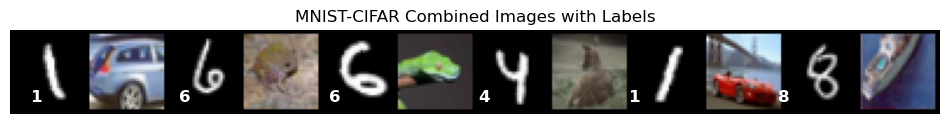

In [8]:
# Use this to plot the images and double check which data you're using
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to show a batch of combined MNIST-CIFAR images with their labels
def show_combined_images_with_labels(dataloader, num_images=6):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # Get first batch

    # Select only the first `num_images` images
    images = images[:num_images]
    labels = labels[:num_images]  # Corresponding labels
    #images[:, :, :, :32] = 0 #MNIST blackout images
    #images[:, :, :, 32:] = 0 #CIFAR blackout images, meaning CIFAR is blacked out and only MNIST is visible

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=num_images, padding=2, normalize=True)

    # Display the images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) for display
    plt.axis("off")

    # Add labels to the images
    for i in range(num_images):
        label = labels[i].item()  # Get label (make sure it's a scalar)
        plt.text(
            i * 64 + 8,  # x position
            30,  # y position (near the bottom of the image)
            str(label),  # Label text
            color='white',  # White color for the text
            fontsize=12,
            fontweight='bold'
        )

    plt.title("MNIST-CIFAR Combined Images with Labels")
    plt.show()

# Call function to display images with labels
show_combined_images_with_labels(combined_loader)

In [234]:
#define the archecture for the imported models
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 13 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool2(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 13 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Instantiate the model
net = Net()

In [235]:
#This loads the two trained model. Model 1 is trained on corolated data, model 2 is trained on CIFAR dominant data 
net1 = torch.load('model_cifar_mnist_1_full.pth')
net2 = torch.load('model_cifar_mnist_2_full.pth')

/var/folders/w5/cr9dv6h106v9sddn3p0_pt200000gn/T/ipykernel_29304/721189659.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net1 = torch.load('model_cifar_mnist_1_full.pt

In [231]:
#Choose which model to work with

In [11]:
#This evaluates the model performance based on whatever data is loaded
def calculate_class_accuracies(model, testloader, classes):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct predictions for each class
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    # Iterate through the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            # Update correct predictions for each class
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1

    # Print accuracy for each class
    total_correct = 0
    total_images = 0
    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'Accuracy for {classes[i]}: {accuracy:.2f}%')
        total_correct += class_correct[i]
        total_images += class_total[i]
    
    total_accuracy = (total_correct / total_images) * 100
    print("total_accuracy", total_accuracy)
        

# Example usage: Assuming testloader and class names are defined
# The 'classes' should be a list of class names for your dataset (e.g., CIFAR-10 classes)

# Define class names (CIFAR-10 example)
cifar_mnist_classes = ['airplane 0', 'automobile 1', 'bird 2', 'cat 3', 'deer 4', 'dog 5', 
                 'frog 6', 'horse 7', 'ship 8', 'truck 9']

# Call the function to calculate and print class-wise accuracies
calculate_class_accuracies(net3, combined_loader, cifar_mnist_classes)

Accuracy for airplane 0: 0.00%
Accuracy for automobile 1: 0.00%
Accuracy for bird 2: 0.00%
Accuracy for cat 3: 0.00%
Accuracy for deer 4: 0.00%
Accuracy for dog 5: 0.00%
Accuracy for frog 6: 0.00%
Accuracy for horse 7: 0.00%
Accuracy for ship 8: 0.00%
Accuracy for truck 9: 100.00%
total_accuracy 9.915000000000001


In [213]:
# Accuracy test
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in combined_loader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 60000 test images: 56.93%


In [1]:
#Stitching network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 13 * 5, 120)
        self.stitch = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.stitch(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
   
net3 = Net()

In [181]:
# Get the state_dict for each model
state_dict_1 = net1.state_dict()
state_dict_2 = net2.state_dict()
state_dict_3 = net3.state_dict()

# Iterate over the state_dict keys and copy weights
keys = list(state_dict_3.keys())
for i, key in enumerate(keys):
    if i < 6:
        # First half from model_A
        state_dict_3[key] = state_dict_2[key]
    elif i > 7:
        # Second half from model_B
        state_dict_3[key] = state_dict_1[key]

# Load the modified state_dict into model_C
net3.load_state_dict(state_dict_3)
net = net3

In [182]:
# Set model to evaluation mode
net3.eval()

# Example: Test with some data
dataiter = iter(combined_loader)
images, labels = next(dataiter)

# Perform inference
outputs = net3(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', predicted)

Predicted: tensor([5, 4, 2, 1, 5, 4, 4, 6, 4, 4, 2, 5, 4, 2, 1, 7, 7, 3, 4, 1, 2, 2, 9, 7,
        5, 5, 4, 4, 2, 5, 8, 1])


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Set up the optimizer for the unfrozen parameters
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)

In [16]:
    epochs = 10
    net = net3 
    # Freeze all layers initially
    for param in net.parameters():
        param.requires_grad = False
    
    #Unfreeze stitching layer
    for param in net.stitch.parameters():
        param.requires_grad = True
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(combined_loader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')

[1,   500] loss: 0.576
[1,  1000] loss: 0.576
[1,  1500] loss: 0.576
[2,   500] loss: 0.576
[2,  1000] loss: 0.576
[2,  1500] loss: 0.576
[3,   500] loss: 0.576
[3,  1000] loss: 0.576
[3,  1500] loss: 0.576
[4,   500] loss: 0.576
[4,  1000] loss: 0.576
[4,  1500] loss: 0.576
[5,   500] loss: 0.576
[5,  1000] loss: 0.576
[5,  1500] loss: 0.576
[6,   500] loss: 0.576
[6,  1000] loss: 0.576
[6,  1500] loss: 0.576
[7,   500] loss: 0.575
[7,  1000] loss: 0.576
[7,  1500] loss: 0.576
[8,   500] loss: 0.575
[8,  1000] loss: 0.576
[8,  1500] loss: 0.576
[9,   500] loss: 0.575
[9,  1000] loss: 0.575
[9,  1500] loss: 0.576
[10,   500] loss: 0.576
[10,  1000] loss: 0.576
[10,  1500] loss: 0.575
Finished Training.


In [17]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in combined_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 60000 test images: 9.92%


In [186]:
total_correct_2 = 0
total_images_2 = 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
    for data in combined_loader:
        images, labels = data

        # Blackout MNIST side (left half of the image)
        images[:, :, :, :32] = 0  # Assuming image shape (B, C, H, W)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images_2 += labels.size(0)
        total_correct_2 += (predicted == labels).sum().item()
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

mnist_blackout_accuracy = total_correct_2 / total_images_2 * 100
print('Model accuracy with MNIST blacked out: {:.2f}%'.format(mnist_blackout_accuracy))

Model accuracy with MNIST blacked out: 61.45%


In [187]:
total_correct_3 = 0
total_images_3 = 0
confusion_matrix = np.zeros([10,10], int)

with torch.no_grad():
    for data in combined_loader:
        images, labels = data

        # Blackout CIFAR side (right half of the image)
        images[:, :, :, 32:] = 0  # Assuming image shape (B, C, H, W)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images_3 += labels.size(0)
        total_correct_3 += (predicted == labels).sum().item()
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

cifar_blackout_accuracy = total_correct_3 / total_images_3 * 100
print('Model accuracy with CIFAR blacked out: {:.2f}%'.format(cifar_blackout_accuracy))

Model accuracy with CIFAR blacked out: 20.28%


In [188]:
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
print('Model accuracy with CIFAR blacked out: {:.2f}%'.format(cifar_blackout_accuracy))
print('Model accuracy with MNIST blacked out: {:.2f}%'.format(mnist_blackout_accuracy))

Model accuracy on 60000 test images: 64.52%
Model accuracy with CIFAR blacked out: 20.28%
Model accuracy with MNIST blacked out: 61.45%


In [204]:
compute_loss_sharpness(net1, criterion, combined_loader)

compute_gradient_norm(net1, criterion, combined_loader)

compress_model_numpy(net1)

4115256

In [19]:
import torch
import numpy as np
import gzip
import pickle
import copy  # Import copy for deep cloning of the model

def compute_loss_sharpness(model, loss_fn, testloader, epsilon=1e-3):
    """Computes the sharpness measure by perturbing model parameters without modifying the original model."""
    model.eval()
    total_sharpness = 0.0
    num_batches = 0

    for data, target in testloader:
        data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)

        with torch.no_grad():
            output = model(data)
            original_loss = loss_fn(output, target).item()

        # Clone model
        perturbed_model = copy.deepcopy(model)
        perturbed_model.to(next(model.parameters()).device)

        # Apply perturbation to the cloned model's parameters
        with torch.no_grad():
            for p in perturbed_model.parameters():
                p.add_(epsilon * torch.randn_like(p))  # Apply perturbation directly

        # Compute loss with perturbed parameters
        with torch.no_grad():
            perturbed_output = perturbed_model(data)
            perturbed_loss = loss_fn(perturbed_output, target).item()

        total_sharpness += perturbed_loss - original_loss
        num_batches += 1

    return total_sharpness / num_batches if num_batches > 0 else 0.0


In [20]:
def compute_gradient_norm(model, loss_fn, testloader):
    """Computes the average gradient norm over the test set without modifying the model state."""
    model.eval()
    total_norm = 0.0
    num_batches = 0

    for data, target in testloader:
        data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)

        # Compute loss without modifying model
        with torch.no_grad():
            output = model(data)
            loss = loss_fn(output, target)

        # Compute gradients in a cloned model
        cloned_model = type(model)()  # Create a new instance of the model
        cloned_model.load_state_dict(model.state_dict())
        cloned_model.to(next(model.parameters()).device)
        cloned_model.zero_grad()

        output = cloned_model(data)
        loss = loss_fn(output, target)
        loss.backward()

        batch_norm = torch.sqrt(sum(p.grad.norm()**2 for p in cloned_model.parameters() if p.grad is not None))
        total_norm += batch_norm.item()
        num_batches += 1

    return total_norm / num_batches if num_batches > 0 else 0.0

def compress_model_numpy(model):
    """Compresses the model's parameters into a bit stream."""
    with torch.no_grad():
        weights = np.concatenate([p.cpu().detach().numpy().flatten() for p in model.parameters()])
    model_bytes = pickle.dumps(weights)
    compressed = gzip.compress(model_bytes)
    return len(compressed) * 8  # Size in bits

In [26]:
def compute_loss_sharpness(model, loss_fn, testloader, epsilon=1e-3):
    """Computes the sharpness measure by perturbing model parameters."""
    model.eval()
    total_sharpness = 0.0
    num_batches = 0

    original_params = {name: p.clone() for name, p in model.named_parameters()}

    for data, target in testloader:
        data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)
        
        model.zero_grad()
        output = model(data)
        original_loss = loss_fn(output, target).item()

        # Perturb parameters
        for p in model.parameters():
            p.data += epsilon * torch.randn_like(p)

        perturbed_output = model(data)
        perturbed_loss = loss_fn(perturbed_output, target).item()

        # Restore original parameters
        for name, p in model.named_parameters():
            p.data = original_params[name]

        total_sharpness += perturbed_loss - original_loss
        num_batches += 1

    return total_sharpness / num_batches if num_batches > 0 else 0.0

In [27]:
def compute_gradient_norm(model, loss_fn, testloader):
    """Computes the average gradient norm over the test set."""
    model.eval()
    total_norm = 0.0
    num_batches = 0

    for data, target in testloader:
        data, target = data.to(next(model.parameters()).device), target.to(next(model.parameters()).device)
        
        model.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        
        batch_norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None))
        total_norm += batch_norm.item()
        num_batches += 1

    return total_norm / num_batches if num_batches > 0 else 0.0

In [ ]:
import gzip
import pickle

def compress_model_numpy(model):
    weights = np.concatenate([p.cpu().detach().numpy().flatten() for p in model.parameters()])
    model_bytes = pickle.dumps(weights)
    compressed = gzip.compress(model_bytes)
    return len(compressed) * 8  # Size in bits

In [166]:
def calculate_class_accuracies(model, testloader, classes):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct predictions for each class
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    # Iterate through the test dataset
    with torch.no_grad():  # Don't compute gradients during evaluation
        for data in testloader:
            images, labels = data  # Get images and corresponding labels
            outputs = model(images)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get predicted labels

            # Update correct predictions for each class
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1

    # Print accuracy for each class
    for i in range(len(classes)):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'Accuracy for {classes[i]}: {accuracy:.2f}%')

cifar_mnist_classes = ['airplane 0', 'automobile 1', 'bird 2', 'cat 3', 'deer 4', 'dog 5', 
                 'frog 6', 'horse 7', 'ship 8', 'truck 9']
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Call the function to calculate and print class-wise accuracies
calculate_class_accuracies(net, combined_loader, cifar_classes)

Accuracy for airplane: 98.92%
Accuracy for automobile: 99.23%
Accuracy for bird: 96.19%
Accuracy for cat: 95.69%
Accuracy for deer: 97.48%
Accuracy for dog: 97.01%
Accuracy for frog: 98.53%
Accuracy for horse: 98.04%
Accuracy for ship: 97.52%
Accuracy for truck: 98.03%


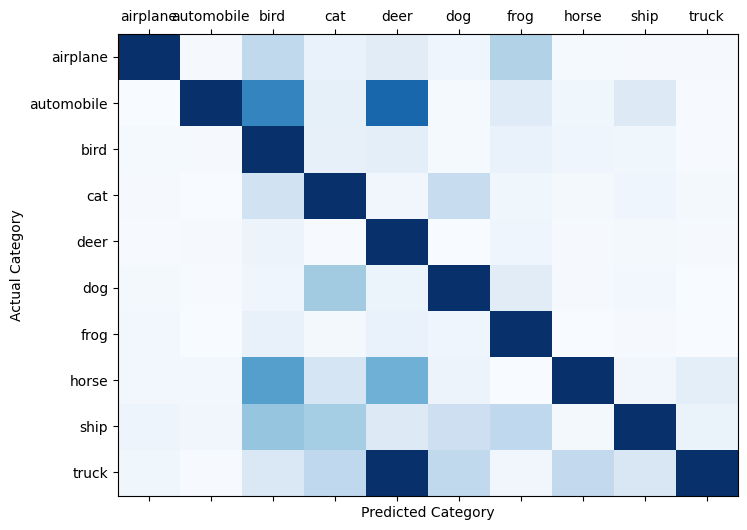

In [167]:
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), cifar_labels)
plt.xlabel('Predicted Category')
plt.xticks(range(10), cifar_labels)
plt.show()